In [1]:
import time

from IPython.display import HTML

import numpy as np
import matplotlib.pyplot as plt
plt.rcdefaults()
import matplotlib.ticker as ticker
import torch
from tqdm import tqdm

from threedeequadsim import quadsim, controller, trajectory, experiments, utils

import importlib
importlib.reload(controller)
importlib.reload(quadsim)
importlib.reload(trajectory)

<module 'threedeequadsim.trajectory' from 'c:\\Users\\mtoc1\\Documents\\github\\Online-Meta-Adaptive-Control-OMAC-Algorithm\\quadsim\\threedeequadsim\\trajectory.py'>

In [2]:
test_name = 'hover' # {'hover', 'fig-8'}

In [3]:
nametag = test_name + 'test'

In [4]:
folder = './plots/' + time.strftime('%Y-%m-%d') + '/' + nametag + '/'
if not os.path.isdir(folder):
    os.makedirs(folder)
    print('Created data folder ' + folder)

Created data folder ./plots/2021-10-22/hovertest/


In [5]:
def savefig(plottag):
    plt.savefig(folder + plottag + '.png', bbox_inches='tight')
# def savefig(plottag):
#     pass
xyz = ['x', 'y', 'z']

In [6]:
eta_a = 0.005

eta_A_convex = 0.0005
eta_A_biconvex = 0.0002
eta_A_deep = 0.05

dim_a = 50
dim_A = 100
layer_sizes = (75, 150)

feature_freq = 0.5

In [7]:
q_kwargs = {
    'Vwind' : np.array((5.0, 0, 0)),            # mean wind speed
    'wind_model': 'iid-uniform',                # {'iid', 'random-walk'}
    # 'Vwind_cov' : 7.5,                        # how quickly the wind changes
    # 'wind_constraint' : 'hard',               # 'hard' wind constraint limits wind speed to be within Vwind_gust of the mean speed
    'Vwind_gust' : np.array((5.0, 0., 2.5)),    # for hard wind constrant, wind speed is in the range Vwind +/- Vwind_gust
    'wind_update_period' : 2.0,                 # seconds between wind speed changes
    't_stop' : 30.,
}

In [8]:
CTRLS = [
    # controller.Baseline(),
    controller.MetaAdaptBaseline(eta_a_base=eta_a, dim_a=dim_a, feature_freq=feature_freq),
    controller.MetaAdaptConvex(eta_a_base=eta_a, eta_A_base=eta_A_convex, dim_a=dim_a, dim_A=dim_A, feature_freq=feature_freq),
    controller.MetaAdaptBiconvex(eta_a_base=eta_a, eta_A_base=eta_A_biconvex, dim_a=dim_a, dim_A=dim_A, feature_freq=feature_freq),
    controller.MetaAdaptDeep(eta_a_base=eta_a, eta_A_base=eta_A_deep, dim_a=dim_a, layer_sizes=layer_sizes),
    controller.Omniscient()
]

In [9]:
if test_name == 'hover':
    T = trajectory.hover

    t_kwargs = {
        'pd' : np.zeros(3)
    }

elif test_name == 'fig-8':
    T = trajectory.fig8
    t_kwargs = {
        'T': np.pi * 1.5
    }

In [10]:
Data = []

for c in CTRLS:
    q = quadsim.QuadrotorWithSideForce(**q_kwargs, )    # create a quadrotor object
    t = T(**t_kwargs)                                   # create a trajectory object and initialize the trajectory

    data = q.run(trajectory=t, controller=c, seed=842210066 )  # run the simulation
                                                        # note: this will set the seed, call c.reset_controller(), then reset the seed again
    Data.append(data)                                   # save the results

3001it [00:41, 72.33it/s]                            
3001it [00:41, 73.11it/s]                            
3001it [00:40, 73.35it/s]                            
3001it [00:44, 66.99it/s]                            
3001it [00:40, 74.86it/s]                            


In [11]:
print('%15s, %6s, %15s' % ('Controller', 'ACE', 'Steady State ACE'))

err = []
err_ss = []
for i, (c, data) in enumerate(zip(CTRLS, Data)):
    err.append(experiments.get_error(data['X'], data['pd']))
    err_ss.append(experiments.get_error(data['X'], data['pd'], istart=1000)) # ss=steady state
    print('%15s, %5.4f, %5.4f' % (c._name, err[-1]['meanerr'], err_ss[-1]['meanerr']))

     Controller,    ACE, Steady State ACE
  baseline-omac, 0.0882, 0.0812
    convex-omac, 0.1077, 0.1114
  biconvex-omac, 0.0782, 0.0400
      deep-omac, 0.0955, 0.0485
     omniscient, 0.0278, 0.0247


In [12]:
color = ((1,0,0), (0,1,0), (0,0,1)) # colors for x, y and z directions

baseline-omac
convex-omac
biconvex-omac
deep-omac
omniscient


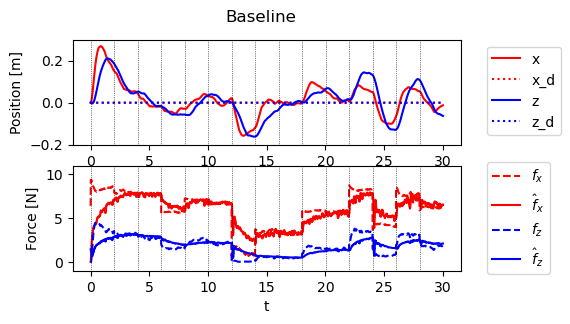

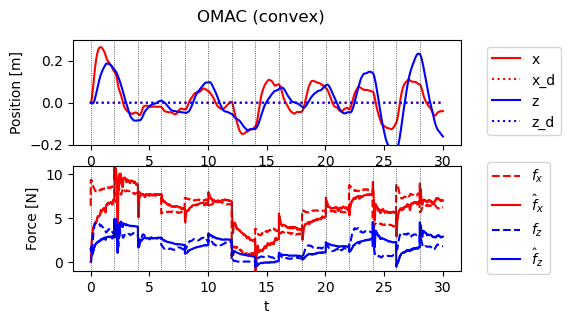

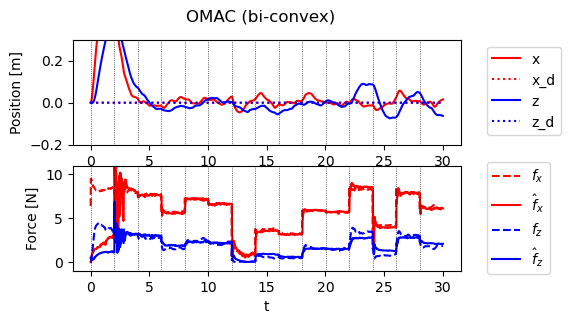

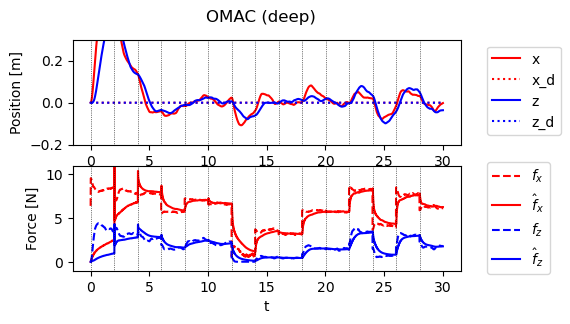

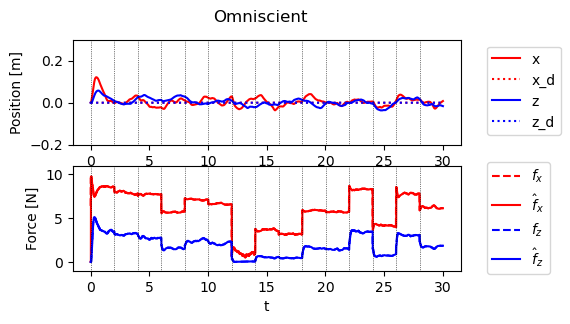

In [13]:
for j, data in enumerate(Data):
    if CTRLS[j]._name == 'baseline':
        continue
    
    print(CTRLS[j]._name)

    plt.figure(figsize=(5,3))

    # Plot position tracking
    plt.subplot(2,1,1)
    for i in [0, 2]: # only plot x and z
        # plt.subplot(2,3,i+1)
        plt.plot(data['t'], data['X'][:,i], label=xyz[i], color = color[i])
        plt.plot(data['t'], data['pd'][:,i], ':', label=xyz[i] + '_d', color = color[i])
        # plt.plot(data['t'], data['Vwind'][:,i], label='Vwind_' + xyz[i])
    plt.legend(bbox_to_anchor=(1.05, 1.))
    for t in data['t'][data['meta_adapt_trigger']]:
        plt.axvline(t, ls=':', color='k', lw=0.5)
    plt.xlabel('t')
    plt.ylabel('Position [m]')
    # plt.ylabel(xyz[i])
    plt.ylim((-0.2, 0.3))

    # Plot force estimation
    plt.subplot(2,1,2)
    for i in [0, 2]:
        # plt.subplot(2,3,i+4)
        plt.plot(data['t'], data['Fs'][:,i], '--', label=r'$f_' + xyz[i] + '$', color = color[i])
        plt.plot(data['t'], data['f_hat'][:,0,i], label=r'$\hat{f}_' + xyz[i] + '$', color = color[i])
    plt.legend(bbox_to_anchor=(1.05, 1.1))
    for t in data['t'][data['meta_adapt_trigger']]:
        plt.axvline(t, ls=':', color='k', lw=0.5)
    plt.xlabel('t')
    plt.ylabel('Force [N]')
    # plt.ylabel(xyz[i])
    plt.ylim((-1, 11))

    plt.suptitle(CTRLS[j].name_long)
    savefig('xz-performance_' + CTRLS[j]._name)

baseline-omac
0 0
convex-omac
0 1
biconvex-omac
0 2
deep-omac
0 3


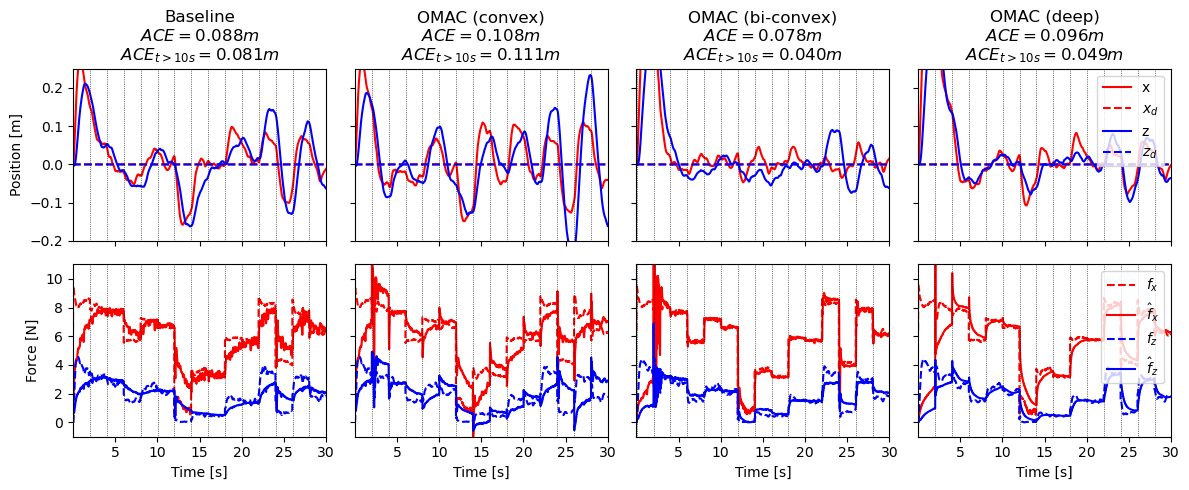

In [21]:
fig = plt.figure(figsize=(12, 5))
# gs = fig.add_gridspec(2,2)
rows = 1
cols = 4 # int(len(Data)/rows)
gs = plt.GridSpec(2 * rows, cols)
for j, data in enumerate(Data):
    if CTRLS[j]._name in {'pid', 'omniscient'}:
        continue
    
    print(CTRLS[j]._name)


    # Plot quadrotor
    row = 0 # int(j / cols)
    col = j # % cols
    print(row, col)

    # Plot position tracking
    ax = fig.add_subplot(gs[row*2, col])
    for i in [0, 2]: # only plot x and z
        plt.plot(data['t'], data['X'][:,i], label=xyz[i], color = color[i])
        plt.plot(data['t'], data['pd'][:,i], '--', label=r'$' + xyz[i] + '_d$', color = color[i])
    for t in data['t'][data['meta_adapt_trigger']]:
        plt.axvline(t, ls=':', color='k', lw=0.5)

    plt.margins(x=0)

    if j == len(Data) - 2:
        plt.legend(loc = 'upper right')
    ax.axes.xaxis.set_ticklabels([])
    if col == 0:
        plt.ylabel('Position [m]')
    else:
        ax.axes.yaxis.set_ticklabels([])
    plt.ylim((-0.2, 0.25))
    plt.title(CTRLS[j].name_long + '\n$ACE=%.3f m$\n$ACE_{t>10s}=%.3fm$' % (err[j]['meanerr'], err_ss[j]['meanerr']))

    # Plot force estimation
    ax = fig.add_subplot(gs[row*2+1, col])
    for i in [0, 2]:
        plt.plot(data['t'], data['Fs'][:,i], '--', label=r'$f_' + xyz[i] + '$', color = color[i])
        if CTRLS[j]._name == 'baseline':
            plt.plot(data['t'], -data['i_term'][:,i], '-', label=r'$K_i\int\tilde{p}_' + xyz[i] + 'dt$', color = color[i])
        else:
            plt.plot(data['t'], data['f_hat'][:,0,i], '-', label=r'$\hat{f}_' + xyz[i] + '$', color = color[i])
    for t in data['t'][data['meta_adapt_trigger']]:
        plt.axvline(t, ls=':', color='k', lw=0.5)
    
    plt.margins(x=0)

    if j == len(Data) - 2:
        plt.legend(loc = 'upper right')
    if row == rows-1:
        plt.xlabel('Time [s]')
    else: 
        ax.axes.xaxis.set_ticklabels([])
    if col == 0:
        plt.ylabel('Force [N]')
    else:
        ax.axes.yaxis.set_ticklabels([])
    plt.ylim((-1, 11))

plt.tight_layout()
savefig('performance_combined')

In [15]:
row*2

0

In [16]:
import rowan
import collections
import os
import shutil
from tqdm import tqdm

In [17]:
Circle = collections.namedtuple('Circle', 'center radius normal ax1 ax2', defaults=((0., 0., 0.), (0., 0., 0.)))
l_arm = 0.3 / 2
D = 0.45 / 2 # params['D'] * 3
h = 0.10 / 2 # params['h']
lines = (((0.,0.,0.),(l_arm,l_arm,0.)),
                ((0.,0.,0.),(-l_arm,l_arm,0.)),
                ((0.,0.,0.),(-l_arm,-l_arm,0.)),
                ((0.,0.,0.),(l_arm,-l_arm,0.)),
                ((l_arm,l_arm,0.),(l_arm,l_arm,h)),
                ((-l_arm,l_arm,0.),(-l_arm,l_arm,h)),
                ((-l_arm,-l_arm,0.),(-l_arm,-l_arm,h)),
                ((l_arm,-l_arm,0.),(l_arm,-l_arm,h)),
                )
# Make circles mutable so that we can update the ax1 and ax2 fields
circles = [Circle((l_arm, l_arm, h), D/2, (0., 0., 1.)),
                Circle((-l_arm, l_arm, h), D/2, (0., 0., 1.)),
                Circle((-l_arm, -l_arm, h), D/2, (0., 0., 1.)),
                Circle((l_arm, -l_arm, h), D/2, (0., 0., 1.)),]

for i, (center, radius, normal, ax1, ax2) in enumerate(circles):
    ax1 = np.cross(normal, (1., 0., 0.))
    if np.linalg.norm(ax1) < 1e-3:
        ax1 = np.cross(normal, (0., 0., 1.))
    ax1 = ax1 / np.linalg.norm(ax1)
    ax2 = np.cross(normal, ax1)
    circles[i] = Circle(np.array(center), radius, np.array(normal), np.array(ax1), np.array(ax2))

In [18]:
def plot_quad(ax, R, p):
    for line in lines:
        x, y, z = R @ np.array(line).transpose() + p[:, np.newaxis]
        ax.plot3D(x,y,z, lw=2, color = (.5,.5,.5))
        
        x, y, z = np.array(line).transpose()
        ax.plot3D(x,y,z, 'r--', lw=1)

    for (center, radius, normal, ax1, ax2) in circles:
        Rcenter = R @ center
        Rax1 = R @ ax1
        Rax2 = R @ ax2
        theta = np.linspace(0, 2*np.pi)
        
        x, y, z = radius * np.outer(Rax1, np.cos(theta)) + radius * np.outer(Rax2, np.sin(theta)) + Rcenter[:, np.newaxis] + p[:, np.newaxis]
        ax.plot3D(x,y,z, 'k', lw=2)

        x, y, z = radius * np.outer(ax1, np.cos(theta)) + radius * np.outer(ax2, np.sin(theta)) + center[:, np.newaxis]
        ax.plot3D(x,y,z, 'r--', lw=1)

Created data folder ./plots/2021-10-22/hovertest//baseline-omac_gif-frames


 73%|███████▎  | 2184/3001 [04:38<01:44,  7.83it/s]


KeyboardInterrupt: 

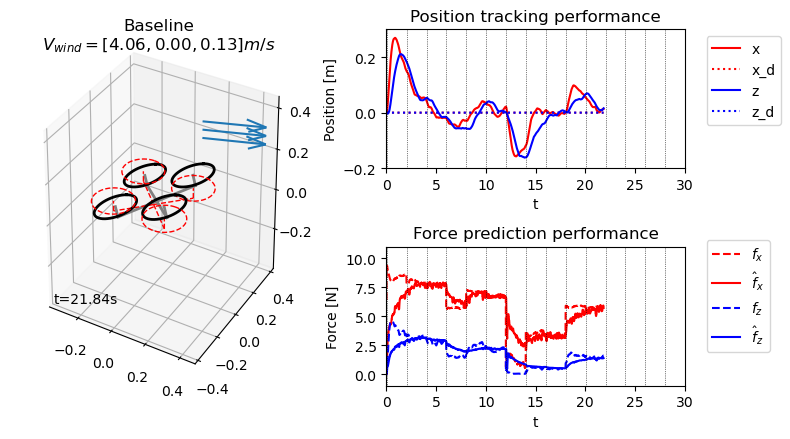

In [19]:
fps = 24.

data = Data[0]
j = 0
if True:
    for j, data in enumerate(Data):
        if CTRLS[j]._name in {'convex-omac', 'biconvex-omac', 'omniscient'}:
            continue
        t_next_frame = 0.
        subfolder = folder + '/' + CTRLS[j]._name + '_gif-frames'
        if os.path.isdir(subfolder):
            print('Warning: overwriting dataset in folder' + subfolder)
            # os.rmdir(folder)
            shutil.rmtree(subfolder)
        os.makedirs(subfolder)
        # if not os.path.isdir(subfolder):
        #     os.makedirs(subfolder)
        print('Created data folder ' + subfolder)

        def saveframe(frameid = [0]):
            plt.savefig(subfolder + '/%04d' % frameid[0], bbox_inches='tight')
            frameid[0] += 1

        xs, ys, zs = np.array(data['X'][:, 0:3]).transpose()
        xmid = (min(xs) + max(xs))/2
        ymid = (min(ys) + max(ys))/2
        zmid = (min(zs) + max(zs))/2
        xwid = max(xs) - min(xs)
        ywid = max(ys) - min(ys)
        zwid = max(zs) - min(zs)
        margin = 0.2
        wid = max((xwid, ywid, zwid)) + 2*margin

        for k, t in tqdm(enumerate(data['t']), total=len(data['t'])):
            if t >= t_next_frame:
                t_next_frame += 1/fps

                fig = plt.figure(figsize=(8,4.5))
                # gs = fig.add_gridspec(2,2)
                gs = plt.GridSpec(2, 2)

                # Plot quadrotor
                ax = fig.add_subplot(gs[:,0], projection='3d')
                # ax = plt.axes(projection='3d')
                p = data['X'][k,:3]
                q = data['X'][k, 3:7]
                R = rowan.to_matrix(q)
                plot_quad(ax, R, p)
                ax.set_xlim(xmid - wid/2, xmid + wid/2)
                ax.set_ylim(ymid - wid/2, ymid + wid/2)
                ax.set_zlim(zmid - wid/2, zmid + wid/2)
                vwind = data['Vwind'][k]
                quiver_x = xmid         + np.array((0, 0, 0))
                quiver_y = ymid + wid/2 + np.array((0, 0, 0))
                quiver_z = zmid + wid/4 + np.array((-0.2, -0.1, -0.0)) * wid / 2.
                wind_scale = lambda x : np.sign(x) * np.sqrt(abs(x)) * wid / 2 / np.sqrt(5)
                quiver_u = wind_scale(vwind[0]) # np.sign(vwind[0]) * np.sqrt(np.abs(vwind[0]))
                quiver_v = wind_scale(vwind[1])
                quiver_w = wind_scale(vwind[2])
                plt.quiver(quiver_x, quiver_y, quiver_z, quiver_u, quiver_v, quiver_w)
                # ax.text(xmid - wid/1.5, ymid + wid/2, zmid + wid/3, r'$V_{wind}=%.2fm/s$' % vwind[0])
                ax.text(xmid - wid/2, ymid - wid/2, zmid - wid/2, 't=%.2fs' % t)
                plt.title(CTRLS[j].name_long + '\n' + r'$V_{wind}=[%.2f,%.2f,%.2f]m/s$' % tuple(vwind))
                

                # Plot position tracking
                plt.subplot(gs[0,1])
                for i in [0, 2]: # only plot x and z
                    plt.plot(data['t'][:k], data['X'][:k,i], label=xyz[i], color = color[i])
                    plt.plot(data['t'][:k], data['pd'][:k,i], ':', label=xyz[i] + '_d', color = color[i])
                plt.legend(bbox_to_anchor=(1.05, 1.))
                for t in data['t'][data['meta_adapt_trigger']]:
                    plt.axvline(t, ls=':', color='k', lw=0.5)
                plt.xlabel('t')
                plt.ylabel('Position [m]')
                plt.ylim(bottom=-0.2, top=0.3)
                plt.xlim(left=0, right=q_kwargs['t_stop'])
                plt.margins(x=0)
                plt.title('Position tracking performance')

                # Plot force estimation
                plt.subplot(gs[1,1])
                for i in [0, 2]:
                    plt.plot(data['t'][:k], data['Fs'][:k,i], '--', label=r'$f_' + xyz[i] + '$', color = color[i])
                    plt.plot(data['t'][:k], data['f_hat'][:k,0,i], label=r'$\hat{f}_' + xyz[i] + '$', color = color[i])
                plt.legend(bbox_to_anchor=(1.05, 1.1))
                for t in data['t'][data['meta_adapt_trigger']]:
                    plt.axvline(t, ls=':', color='k', lw=0.5)
                plt.xlabel('t')
                plt.ylabel('Force [N]')
                plt.ylim((-1,11))
                plt.xlim(left=0, right=q_kwargs['t_stop'])
                plt.margins(x=0)
                plt.title('Force prediction performance')

                plt.tight_layout()
                saveframe()
                plt.close()
                # plt.show()

In [ ]:
fps = 24.

data = Data[0]
j = 0

data = Data[0]

t_next_frame = 0.
subfolder = folder + '/' + 'combined_gif-frames'
if os.path.isdir(subfolder):
    print('Warning: overwriting data in folder' + subfolder)
    # os.rmdir(folder)
    shutil.rmtree(subfolder)
os.makedirs(subfolder)
# if not os.path.isdir(subfolder):
#     os.makedirs(subfolder)
print('Created data folder ' + subfolder)

def saveframe(frameid = [0]):
    plt.savefig(subfolder + '/%04d' % frameid[0], bbox_inches='tight')
    frameid[0] += 1

xs, ys, zs = np.array(data['X'][:, 0:3]).transpose()
xmid = 0. # (min(xs) + max(xs))/2
ymid = 0. # (min(ys) + max(ys))/2
zmid = 0. # (min(zs) + max(zs))/2
wid = 1.

for k, t in tqdm(enumerate(Data[0]['t']), total=len(Data[0]['t'])):
    if t >= t_next_frame:
        t_next_frame += 1/fps

        fig = plt.figure(figsize=(8,4.5))
        # gs = fig.add_gridspec(2,2)
        gs = plt.GridSpec(2, 3)

        for 
        # Plot quadrotor
        ax = fig.add_subplot(gs[:,0], projection='3d')
        # ax = plt.axes(projection='3d')
        p = data['X'][k,:3]
        q = data['X'][k, 3:7]
        R = rowan.to_matrix(q)
        plot_quad(ax, R, p)
        ax.set_xlim(xmid - wid/2, xmid + wid/2)
        ax.set_ylim(ymid - wid/2, ymid + wid/2)
        ax.set_zlim(zmid - wid/2, zmid + wid/2)
        vwind = data['Vwind'][k]
        quiver_x = xmid         + np.array((0, 0, 0))
        quiver_y = ymid + wid/2 + np.array((0, 0, 0))
        quiver_z = zmid + wid/4 + np.array((-0.2, -0.1, -0.0)) * wid / 2.
        wind_scale = lambda x : np.sign(x) * np.sqrt(abs(x)) * wid / 2 / np.sqrt(5)
        quiver_u = wind_scale(vwind[0]) # np.sign(vwind[0]) * np.sqrt(np.abs(vwind[0]))
        quiver_v = wind_scale(vwind[1])
        quiver_w = wind_scale(vwind[2])
        plt.quiver(quiver_x, quiver_y, quiver_z, quiver_u, quiver_v, quiver_w)
        # ax.text(xmid - wid/1.5, ymid + wid/2, zmid + wid/3, r'$V_{wind}=%.2fm/s$' % vwind[0])
        ax.text(xmid - wid/2, ymid - wid/2, zmid - wid/2, 't=%.2fs' % t)
        plt.title(CTRLS[j].name_long + '\n' + r'$V_{wind}=[%.2f,%.2f,%.2f]m/s$' % tuple(vwind))
        

        # Plot position tracking
        plt.subplot(gs[0,1])
        for i in [0, 2]: # only plot x and z
            plt.plot(data['t'][:k], data['X'][:k,i], label=xyz[i], color = color[i])
            plt.plot(data['t'][:k], data['pd'][:k,i], ':', label=xyz[i] + '_d', color = color[i])
        plt.legend(bbox_to_anchor=(1.05, 1.))
        for t in data['t'][data['meta_adapt_trigger']]:
            plt.axvline(t, ls=':', color='k', lw=0.5)
        plt.xlabel('t')
        plt.ylabel('Position [m]')
        plt.ylim(bottom=-0.2, top=0.3)
        plt.xlim(left=0, right=q_kwargs['t_stop'])
        plt.margins(x=0)
        plt.title('Position tracking performance')

        # Plot force estimation
        plt.subplot(gs[1,1])
        for i in [0, 2]:
            plt.plot(data['t'][:k], data['Fs'][:k,i], '--', label=r'$f_' + xyz[i] + '$', color = color[i])
            plt.plot(data['t'][:k], data['f_hat'][:k,0,i], label=r'$\hat{f}_' + xyz[i] + '$', color = color[i])
        plt.legend(bbox_to_anchor=(1.05, 1.1))
        for t in data['t'][data['meta_adapt_trigger']]:
            plt.axvline(t, ls=':', color='k', lw=0.5)
        plt.xlabel('t')
        plt.ylabel('Force [N]')
        plt.ylim((-1,11))
        plt.xlim(left=0, right=q_kwargs['t_stop'])
        plt.margins(x=0)
        plt.title('Force prediction performance')

        plt.tight_layout()
        saveframe()
        plt.close()
        # plt.show()

In [ ]:
# # build gif
# with imageio.get_writer('mygif.gif', mode='I') as writer:
#     for filename in filenames:
#         image = imageio.imread(filename)
#         writer.append_data(image)